In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import scipy.stats as stats
import pandas as pd
import pickle
import os
from sklearn.linear_model import LinearRegression, Ridge

regions = {0: 'imgs', 1: 'caudate', 2: 'cerebellum', 3: 'frontal_lobe', 4: 'insula', 5: 'occipital_lobe', 6: 'parietal_lobe', 7: 'putamen', 8: 'temporal_lobe', 9: 'thalamus'}
root = '/media/leelabsg-storage1/yein/research/test/'
age_diff_groups = {}
disease_l = 'i10'
disease_u = 'I10'

In [28]:
def bias_correction(true, pred):
    reg = LinearRegression().fit(true.reshape(-1, 1), pred)
    beta_0 = reg.intercept_
    beta_1 = reg.coef_[0]

    corrected_pred = (pred - beta_0) / beta_1
    return corrected_pred
    
def bias_correction_with_penalty(true, pred, alpha=1.0):
    true = np.array(true).reshape(-1, 1)
    pred = np.array(pred)
    
    # Ridge regression with regularization parameter alpha
    reg = Ridge(alpha=alpha).fit(true, pred)
    beta_0 = reg.intercept_
    beta_1 = reg.coef_[0]
    
    corrected_pred = (pred - beta_0) / beta_1
    
    return corrected_pred

def pickel_load_cn(root):

    map = dict()
    for _, v in regions.items():
        map[v] = {'pred_ages': [],
                 'true_ages': []}

    
    for cv_num in range(4):
        for content in ['pred_ages', 'true_ages']:
            pickel_path = os.path.join(root, str(cv_num), f'{content}.pickle')
            # print(pickel_path)
            with open(pickel_path, 'rb') as file:
                curr_cv = pickle.load(file) # cv-split size의 dict (region: age_lists)

            for _, v in regions.items():
                map[v][content].extend(curr_cv[v][0])

    # bias corrected pred age
    for region, age_list in map.items():
        print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']))
        pred = np.array(map[region]['pred_ages'])
        true = np.array(map[region]['true_ages'])
        map[region]['corrected_pred_ages'] = bias_correction(true, pred)

    return map


def pickle_load(root):
    map = {v: {'pred_ages': [], 'true_ages': []} for _, v in regions.items()}

    # true_ages 4-cv model results gathering for averaging them
    for cv_num in range(4):
        pickel_path = os.path.join(root, str(cv_num), 'true_ages.pkl')
        if os.path.exists(pickel_path):
            with open(pickel_path, 'rb') as file:
                curr_cv = pickle.load(file)  # cv-split size의 dict (region: age_lists)  # age_lists length: 630
                for region, age_list in curr_cv.items():
                        map[region]['true_ages'] = age_list
    
    # pred_ages 4-cv model results gathering for averaging them
    for cv_num in range(4):
        pickle_path = os.path.join(root, str(cv_num), 'pred_ages.pkl')
        if os.path.exists(pickle_path):
            with open(pickle_path, 'rb') as file:
                curr_cv = pickle.load(file)
                for region, age_list in curr_cv.items():
                        map[region]['pred_ages'].append(age_list)
    # # 평균
    # if cn == False:
    #     for region, _ in map.items():
    #         map[region].setdefault('corrected_pred_ages', [])
    #         pred_ages_lists = map[region]['pred_ages']
    #         for pred in pred_ages_lists:
    #             true = map[region]['true_ages']
    #             # corrected_pred = bias_correction_with_penalty(true, pred, alpha)
    #             corrected_pred = bias_correction(np.array(true), np.array(pred))
    #             map[region]['corrected_pred_ages'].append(corrected_pred)
    #         pred_avg_age = [sum(values) / len(values) for values in zip(*pred_ages_lists)]
    #         map[region]['pred_ages'] = pred_avg_age

    #         corrected_pred_ages_lists = map[region]['corrected_pred_ages']
    #         corrected_pred_avg_age = [sum(values) / len(values) for values in zip(*corrected_pred_ages_lists)]
    #         map[region]['corrected_pred_ages'] = corrected_pred_avg_age

    #         print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']), len(map[region]['corrected_pred_ages']))

    # else:
    #     for region, age_list in map.items():
    #         pred = np.array(map[region]['pred_ages'])
    #         true = np.array(map[region]['true_ages'])
    #         map[region]['corrected_pred_ages'] = bias_correction_with_penalty(true, pred, alpha)
    #         print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']), len(map[region]['corrected_pred_ages']))

    
    for region, _ in map.items():
        pred_ages_lists = map[region]['pred_ages']
        pred_avg_age = [sum(values) / len(values) for values in zip(*pred_ages_lists)]
        map[region]['pred_ages'] = pred_avg_age

           
    # bias corrected pred age
    for region, age_list in map.items():
        print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']))
        pred = np.array(map[region]['pred_ages'])
        true = np.array(map[region]['true_ages'])
        map[region]['corrected_pred_ages'] = bias_correction(true, pred)

    print("=" * 30)
    return map          

def age_dist_plot(region, cn, disease):
    plt.hist(cn[region]['true_ages'], bins=30, alpha=0.5, label='CN', density=True, edgecolor='black')
    plt.hist(disease[region]['true_ages'], bins=30, alpha=0.5, label='Disease', density=True, edgecolor='black')
    plt.title('Age Distribution by group')
    plt.xlabel('Age')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.show()


def age_plot(data, region):
    true = data[region]['true_ages']
    pred = data[region]['pred_ages']
    if region == 'imgs':
        region = 'global'
    plt.figure(figsize=(7, 5))
    plt.scatter(true, pred, alpha=0.2)
    plt.plot([min(true), max(true)], [min(true), max(true)], color='red')  # y=x line
    plt.title(f'{region} ========== True Age and Predicted Age')
    plt.xlabel('True_Age')
    plt.ylabel('Predicted_Age')
    plt.show()

def age_plot_corrected(data, region):
    true = data[region]['true_ages']
    pred = data[region]['corrected_pred_ages']
    if region == 'imgs':
        region = 'global'
    plt.figure(figsize=(7, 5))
    plt.scatter(true, pred, alpha=0.2)
    plt.plot([min(true), max(true)], [min(true), max(true)], color='red')  # y=x line
    plt.title(f'{region} ========== True Age and Corrected Predicted Age')
    plt.xlabel('True_Age')
    plt.ylabel('Predicted_Age')
    plt.show()

def calculate_corrected_age_diff_avg(data, region):
    corrected_pred_ages = np.array(data[region]['corrected_pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    return np.mean(corrected_pred_ages - true_ages)

def age_diff_plot(age_diff_dict, regions):
    fig, ax = plt.subplots(figsize=(12, 8))

    age_diff_max = max(abs(max(age_diff_dict.values())), abs(min(age_diff_dict.values())))

    cmap = plt.get_cmap('coolwarm')
    norm = mcolors.Normalize(vmin=-age_diff_max, vmax=age_diff_max)

    for region, age_diff in age_diff_dict.items():
        color = cmap(norm(age_diff))
        ax.barh(region, age_diff, color=color)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('PAD (years)')

    ax.set_xlabel('Predicted Age Difference (years)')
    ax.set_title('Regional Predicted Age Difference (PAD)')
    plt.show()

# 예측 연령 차이 계산
def calculate_age_diff_avg(data, region):
    pred_ages = np.array(data[region]['pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    return np.mean(pred_ages - true_ages)

def calculate_age_diff_dist(data, region):
    corrected_pred_ages = np.array(data[region]['pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    diff = calculate_corrected_age_diff_avg(data, region)

    plt.hist(corrected_pred_ages, bins=30, alpha=0.5, label='Predicted', density=True, edgecolor='black', color='red')
    plt.hist(true_ages, bins=30, alpha=0.5, label='True', density=True, edgecolor='black', color='grey')
    # plt.hist(diff, bins=30, alpha=0.5, label='Difference', density=True, edgecolor='black')
    plt.title('Age Difference Distribution')
    plt.xlabel('Age Difference')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.show()


def multi_group_age_diff_plot(age_diff_dict, groups, regions):
    fig, ax = plt.subplots(figsize=(12, 8))

    # 그룹별 색상 설정
    colors = {
        'CN': 'blue',
        'Disease': 'red'
    }

    bar_width = 0.2  # 막대의 너비
    index = np.arange(len(regions))  # 지역 인덱스

    # 각 그룹에 대해 PAD 값을 시각화
    for i, group in enumerate(groups):
        pad_values = [age_diff_groups[group][region] for region in regions]
        bar_positions = index + i * bar_width
        ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group])

    ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
    ax.set_yticklabels(regions)
    ax.set_xlabel('Predicted Age Difference (years)')
    ax.set_title('Regional Predicted Age Difference (PAD) by Group')
    ax.legend()
    plt.show()

In [19]:
cn_root = root + 'ukb'
cn_ages = pickel_load_cn(cn_root)
disease_root = root + f'ukb_{disease_l}'
disease_ages = pickle_load(disease_root)

imgs 25656 25656
caudate 25656 25656
cerebellum 25656 25656
frontal_lobe 25656 25656
insula 25656 25656
occipital_lobe 25656 25656
parietal_lobe 25656 25656
putamen 25656 25656
temporal_lobe 25656 25656
thalamus 25656 25656
imgs 1605 1605
caudate 1605 1605
cerebellum 1605 1605
frontal_lobe 1605 1605
insula 1605 1605
occipital_lobe 1605 1605
parietal_lobe 1605 1605
putamen 1605 1605
temporal_lobe 1605 1605
thalamus 1605 1605


# age distribution by group

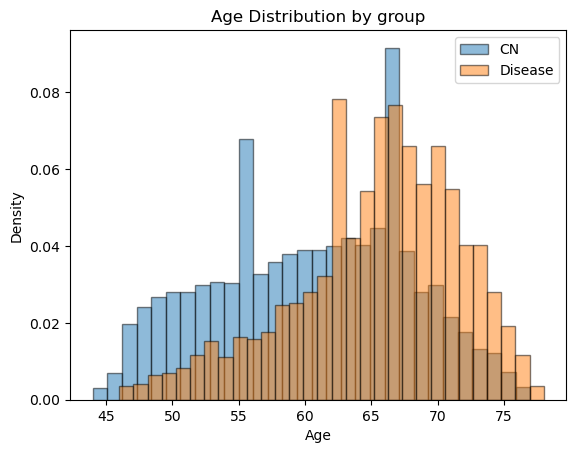

In [15]:
age_dist_plot('imgs', cn_ages, disease_ages)

In [22]:
def age_describe_group(group):
    df = pd.read_csv(f'/media/leelabsg-storage1/yein/research/BAE/RegionBAE/data/ukbb_{group}_region.csv')
    print(df['age'].describe())


age_describe_group('cn')
age_describe_group(disease_u)

count    25656.000000
mean        60.416004
std          7.382716
min         44.000000
25%         54.750000
50%         61.000000
75%         66.000000
max         77.000000
Name: age, dtype: float64
count    1605.000000
mean       65.363240
std         6.260315
min        46.000000
25%        62.000000
50%        66.000000
75%        70.000000
max        78.000000
Name: age, dtype: float64


# CN

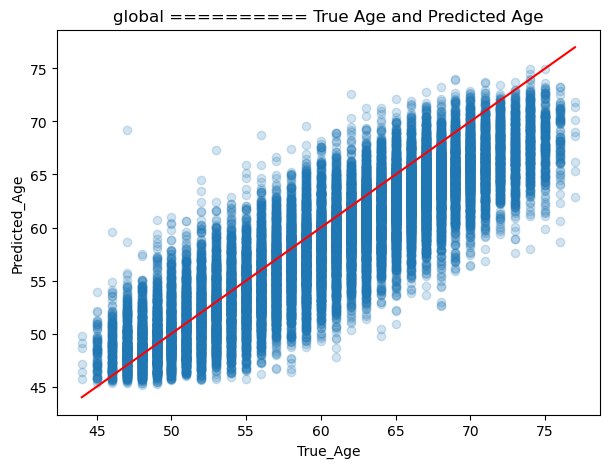

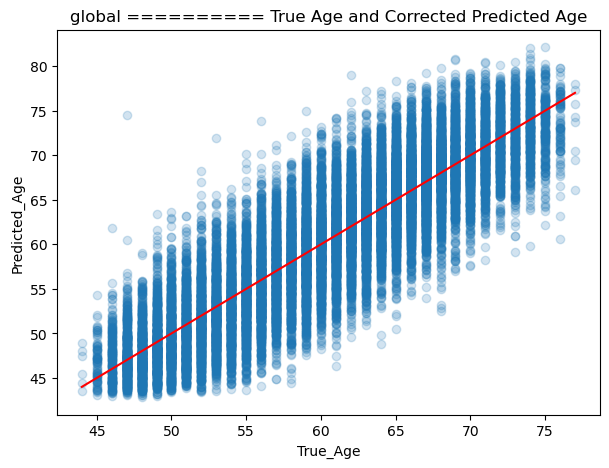

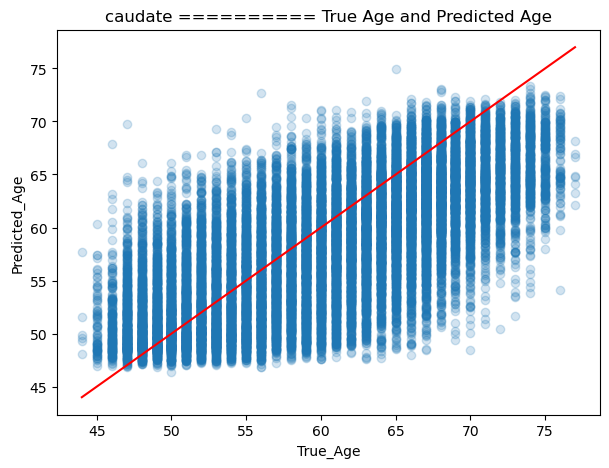

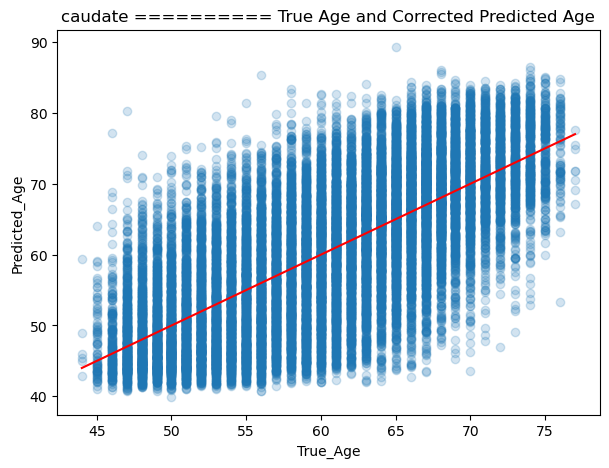

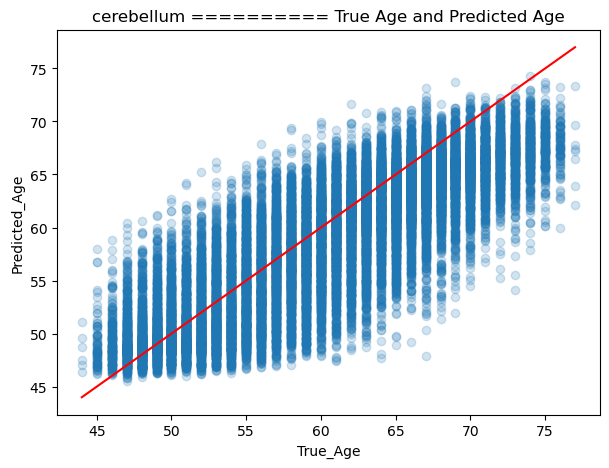

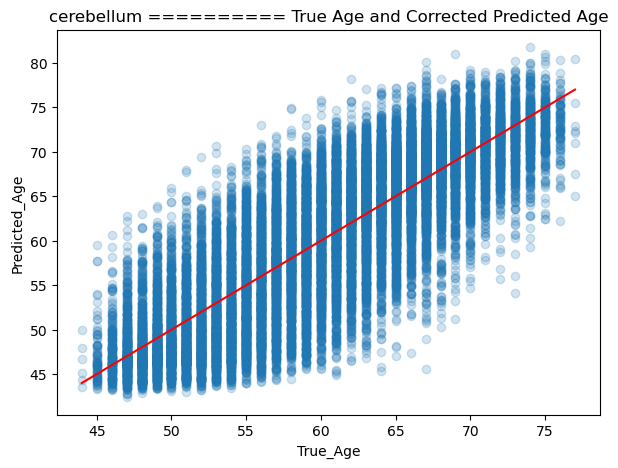

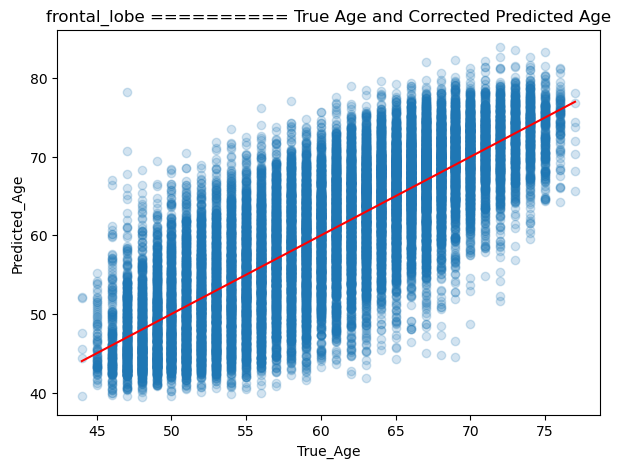

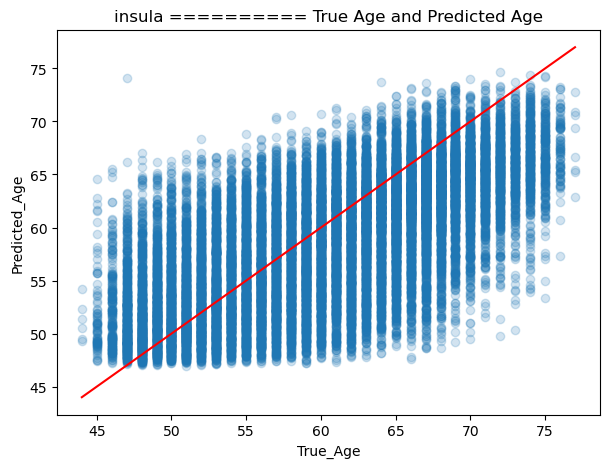

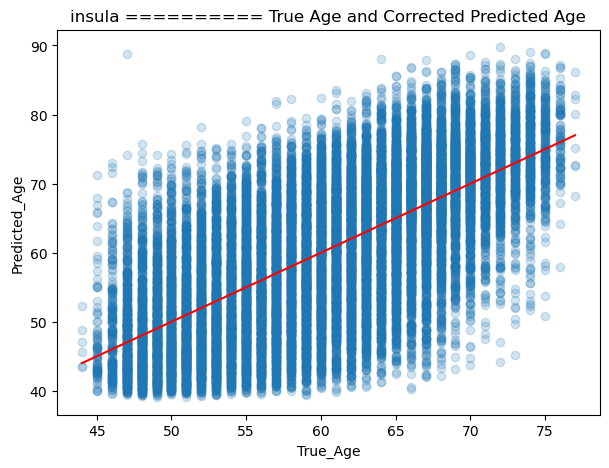

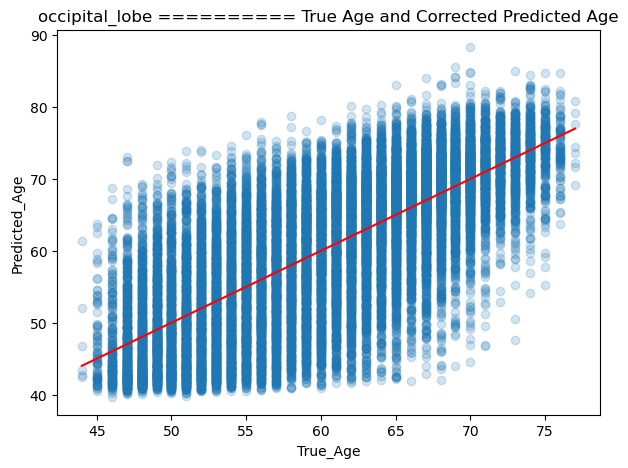

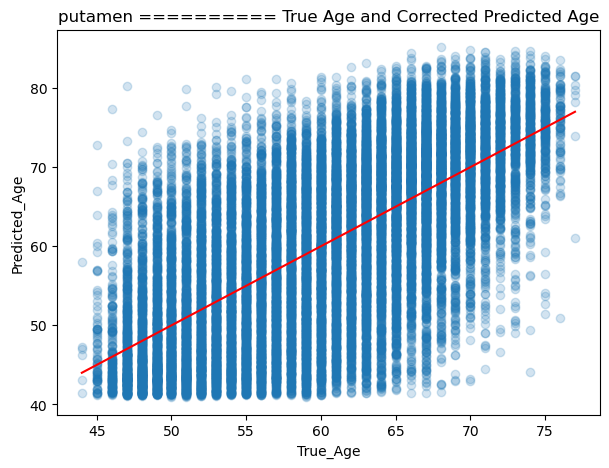

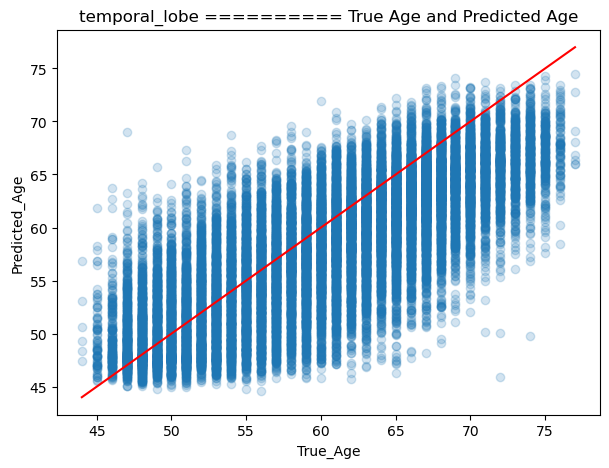

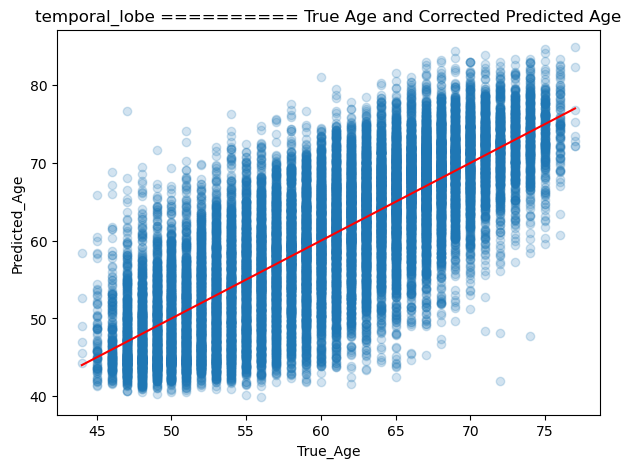

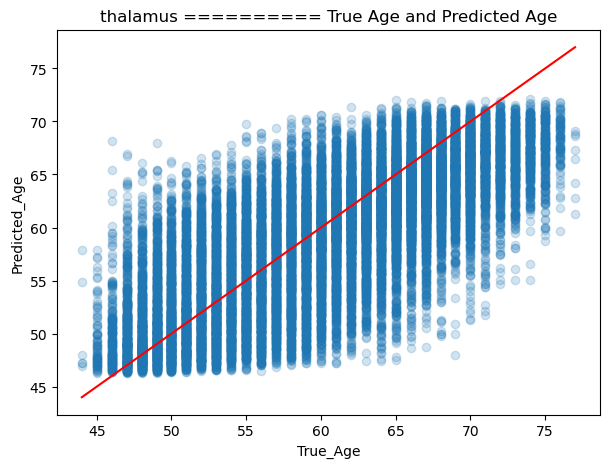

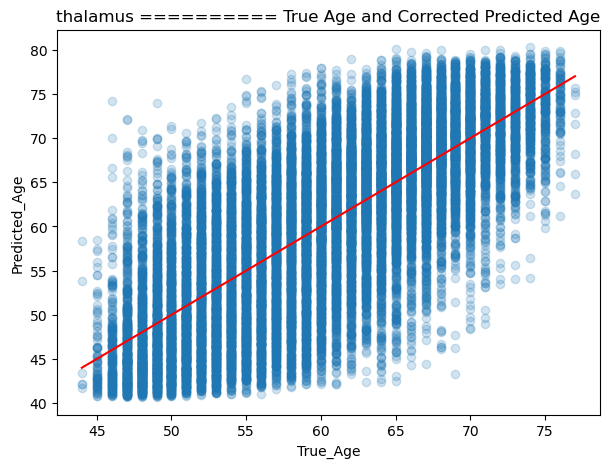

In [41]:
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['CN'] = dict()

for key, region in regions.items():
    age_plot(cn_ages, region)
    age_plot_corrected(cn_ages, region)
    # age_diff_dict[region] = calculate_age_diff_avg(cn_ages, region)
    age_diff_dict[region] = calculate_corrected_age_diff_avg(cn_ages, region)
    age_diff_groups['CN'][region] = age_diff_dict[region]

# 시각화
age_diff_plot(age_diff_dict, regions.values())

# Disease

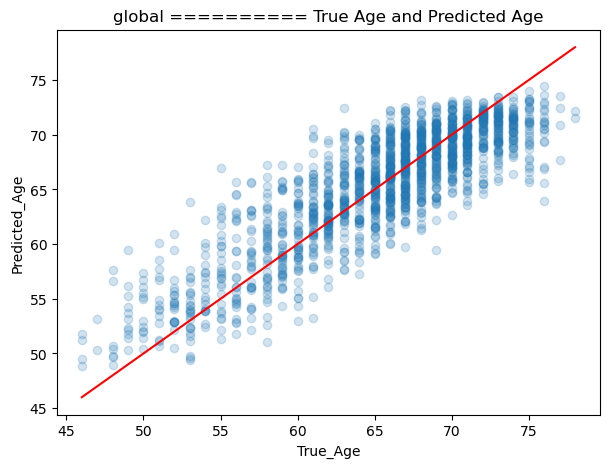

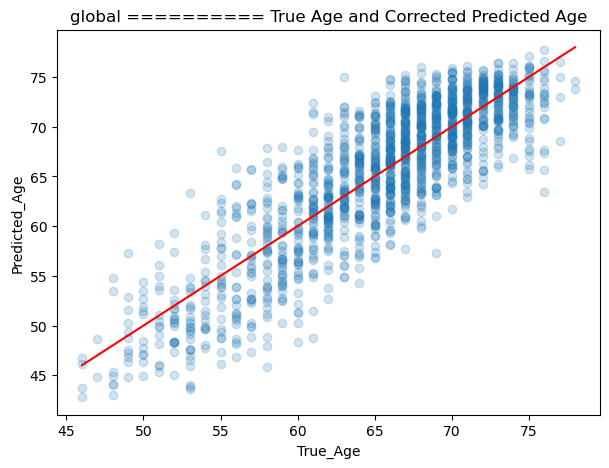

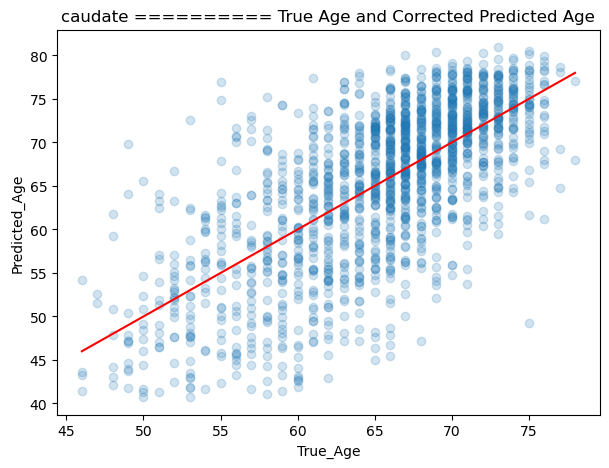

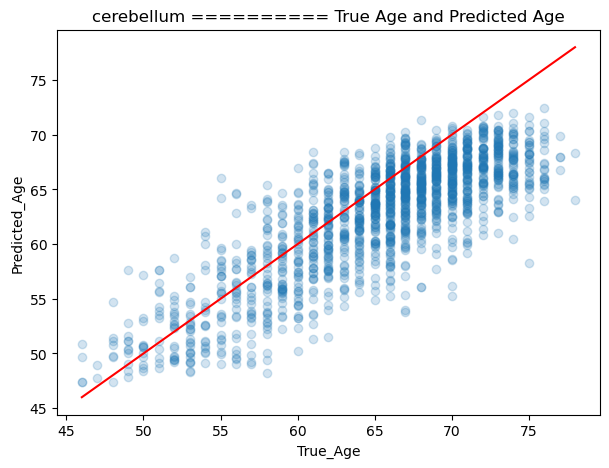

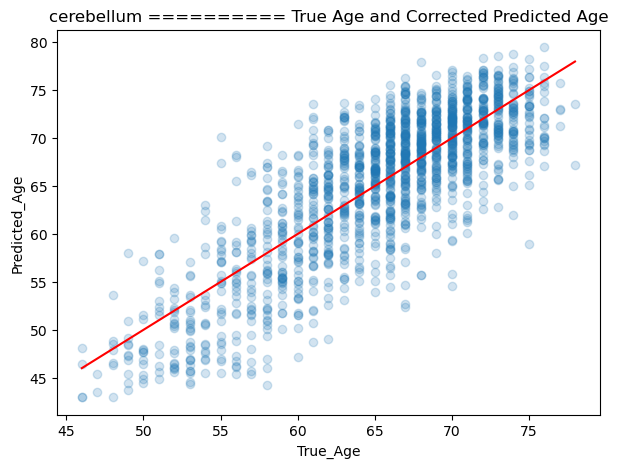

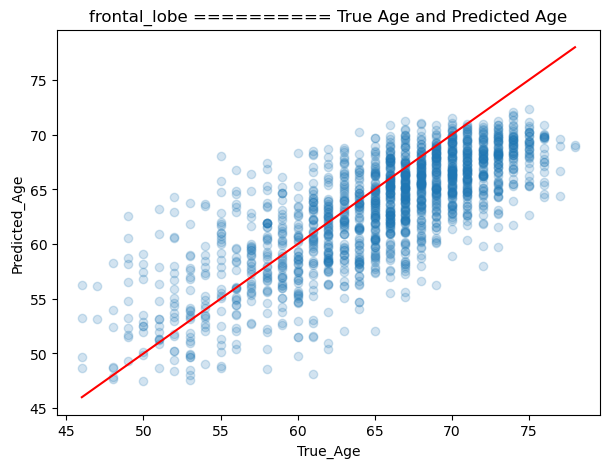

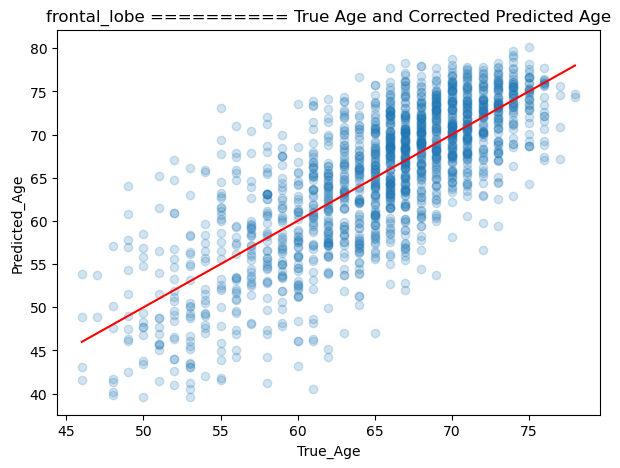

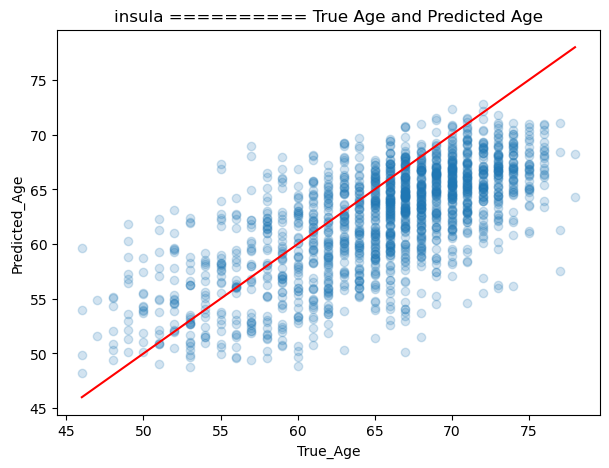

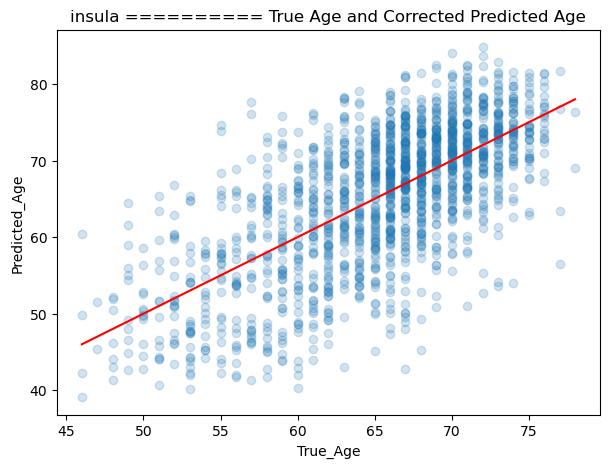

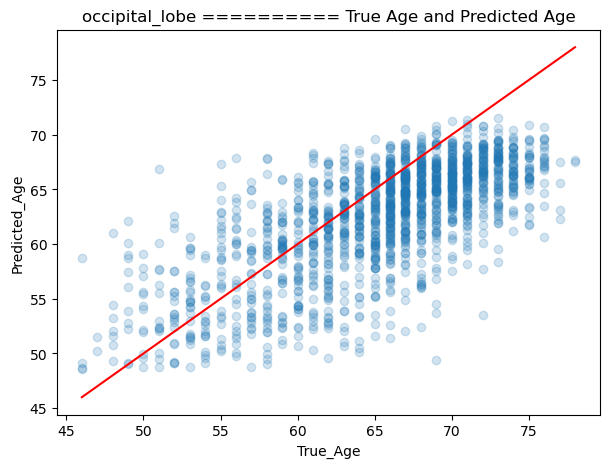

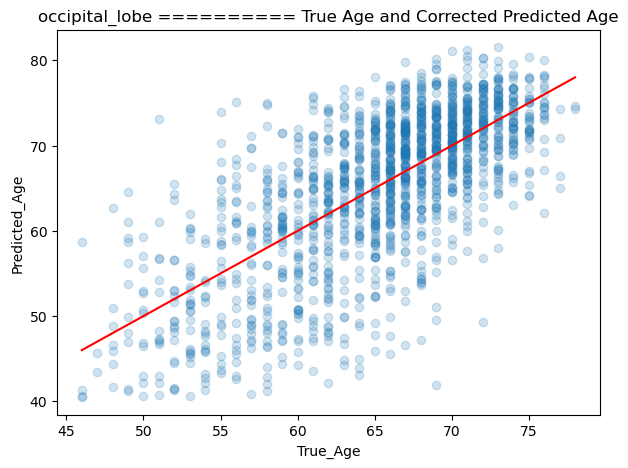

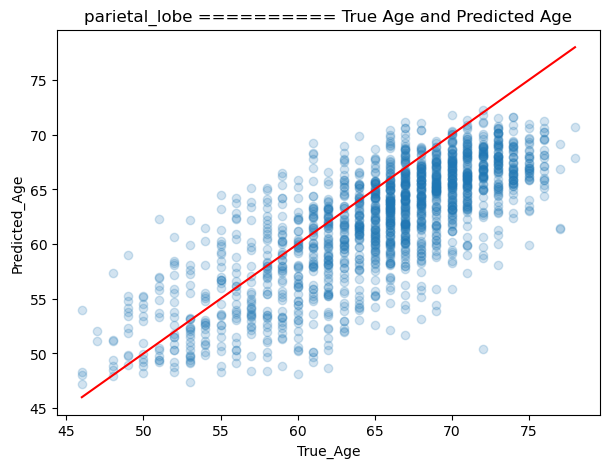

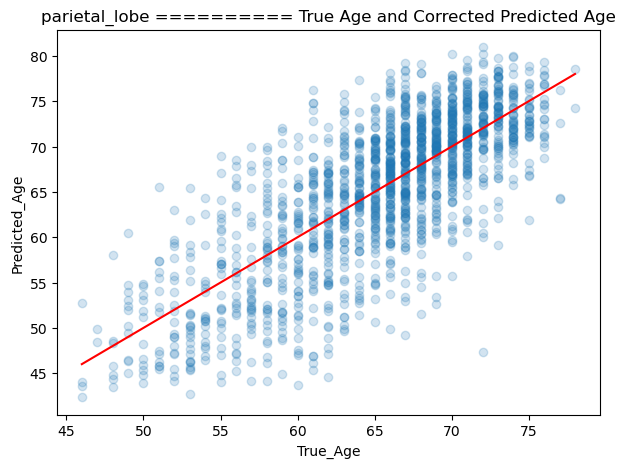

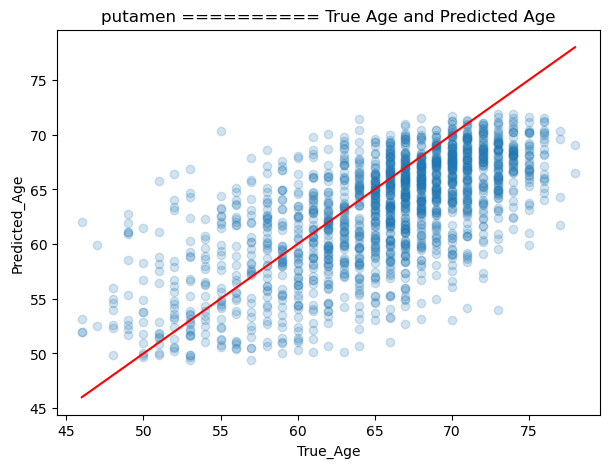

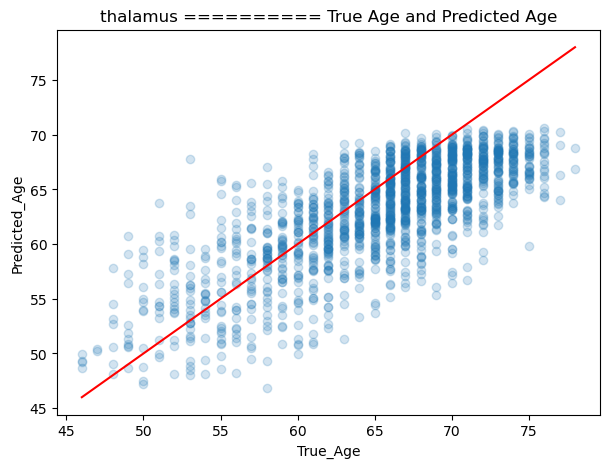

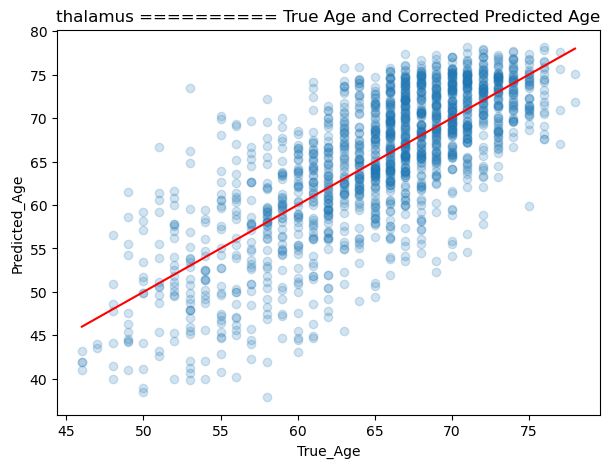

In [42]:
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['Disease'] = dict()

for key, region in regions.items():
    age_plot(disease_ages, region)
    age_plot_corrected(disease_ages, region)
    # age_diff_dict[region] = calculate_age_diff_avg(disease_ages, region)
    age_diff_dict[region] = calculate_corrected_age_diff_avg(disease_ages, region)
    age_diff_groups['Disease'][region] = age_diff_dict[region]

# 시각화
age_diff_plot(age_diff_dict, regions.values())

# Regional Predicted Age Difference (PAD) by Group

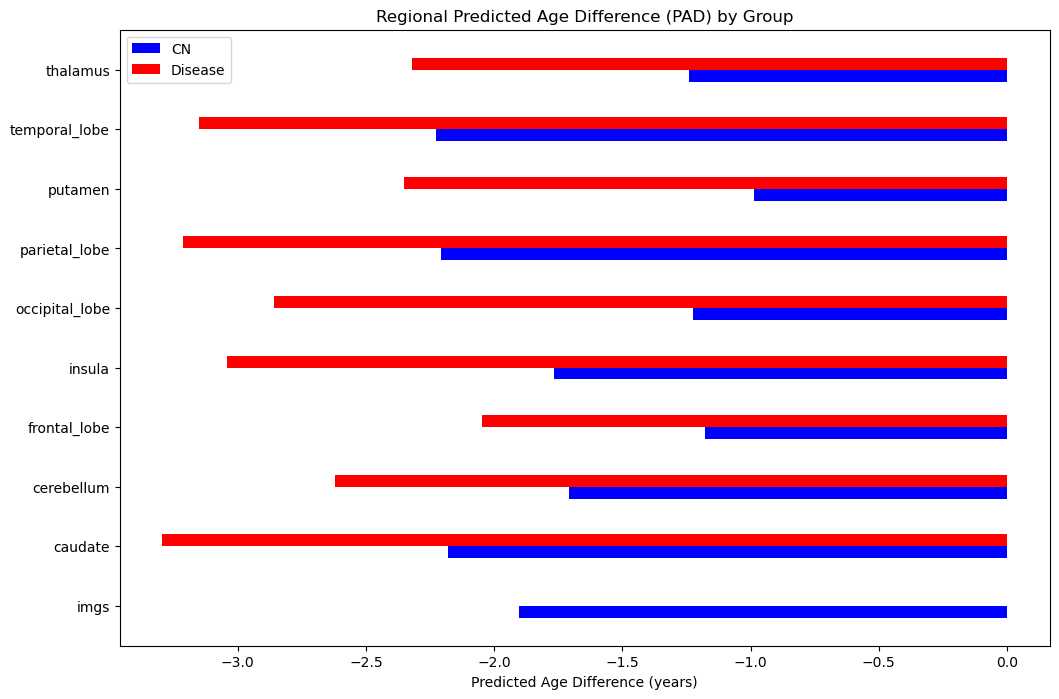

In [40]:
# 시각화
multi_group_age_diff_plot(age_diff_groups, ['CN', 'Disease'], regions.values())

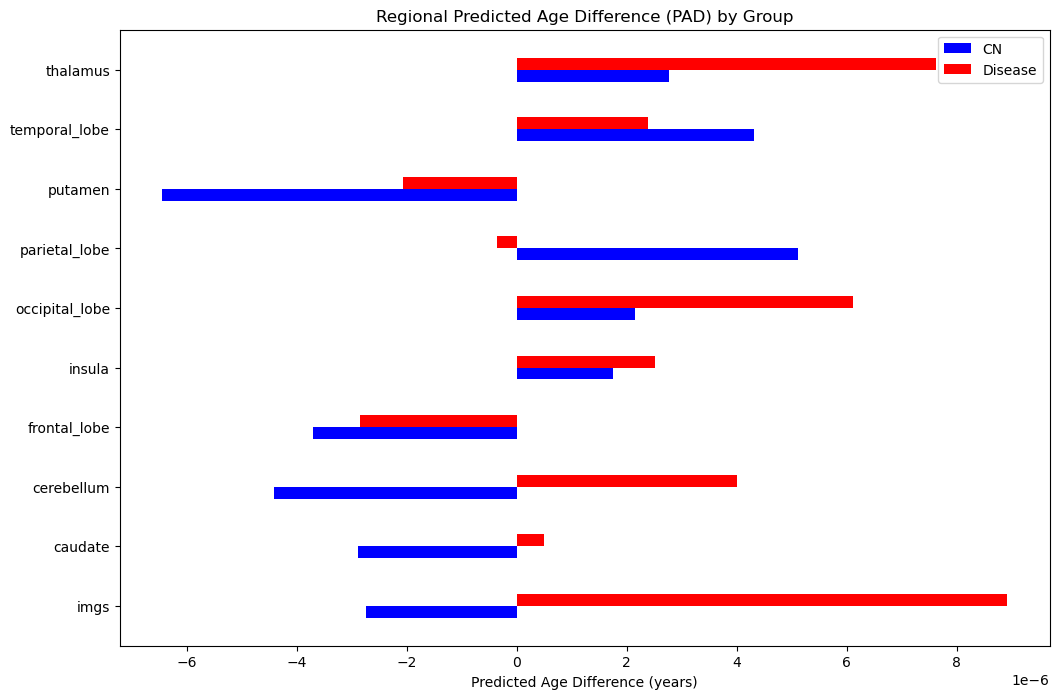

In [43]:
multi_group_age_diff_plot(age_diff_groups, ['CN', 'Disease'], regions.values())

In [30]:
age_diff_groups['CN']

{'imgs': -1.9017644,
 'caudate': -2.1808999,
 'cerebellum': -1.7100071,
 'frontal_lobe': -1.1760193,
 'insula': -1.7665696,
 'occipital_lobe': -1.2255896,
 'parietal_lobe': -2.2081954,
 'putamen': -0.98715097,
 'temporal_lobe': -2.2248087,
 'thalamus': -1.2392694}

In [31]:
age_diff_groups['Disease']

{'imgs': 0.0010899808176581362,
 'caudate': -3.2956041270698715,
 'cerebellum': -2.619744499895803,
 'frontal_lobe': -2.0473207889687606,
 'insula': -3.040792288735648,
 'occipital_lobe': -2.858683782797365,
 'parietal_lobe': -3.2118587749398015,
 'putamen': -2.3503762105543666,
 'temporal_lobe': -3.1495088660457053,
 'thalamus': -2.319378147541177}

# Age Difference Distribution

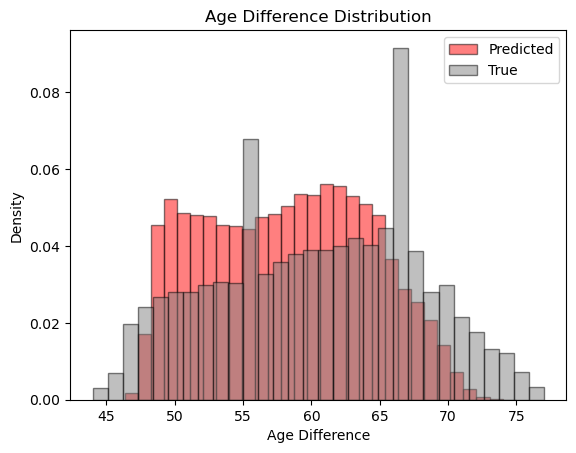

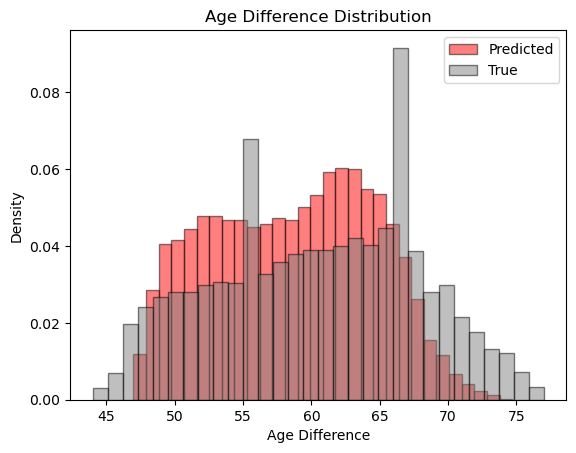

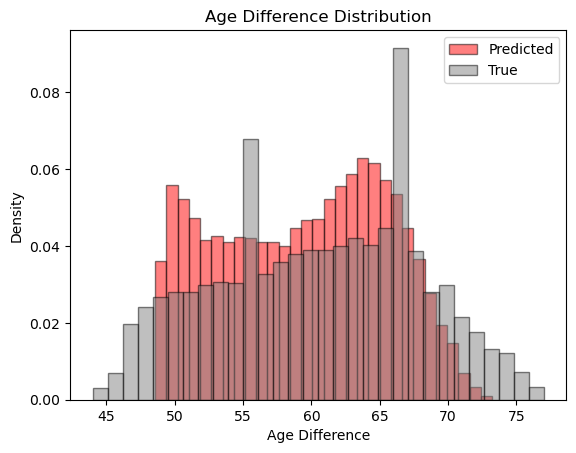

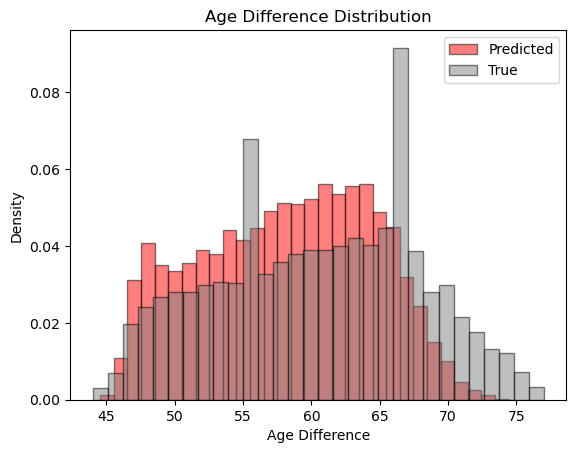

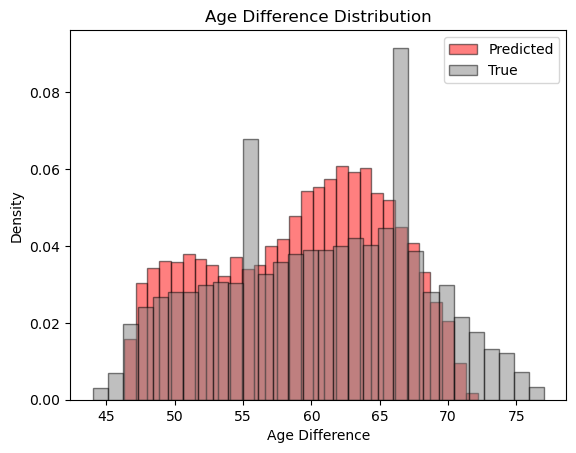

In [33]:
for key, region in regions.items():
    calculate_age_diff_dist(cn_ages,region)

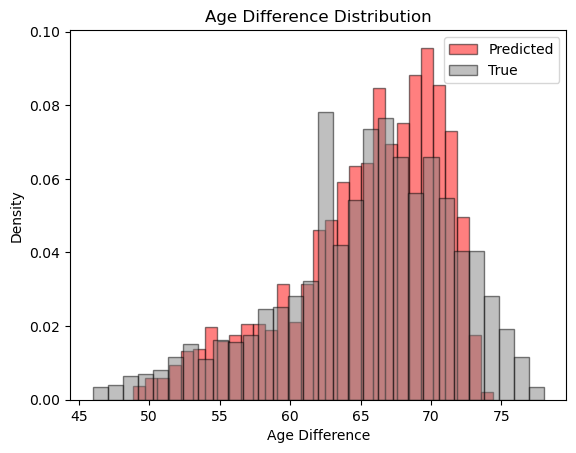

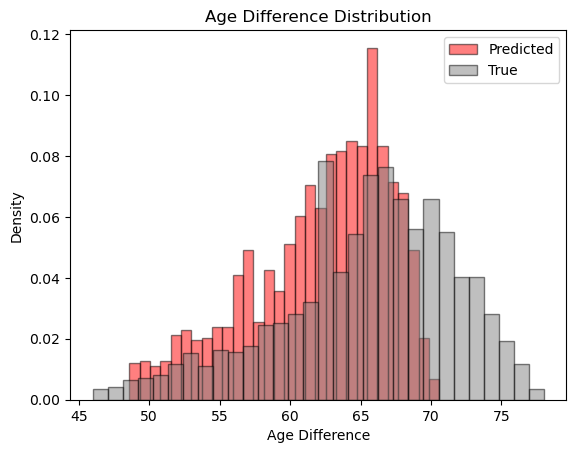

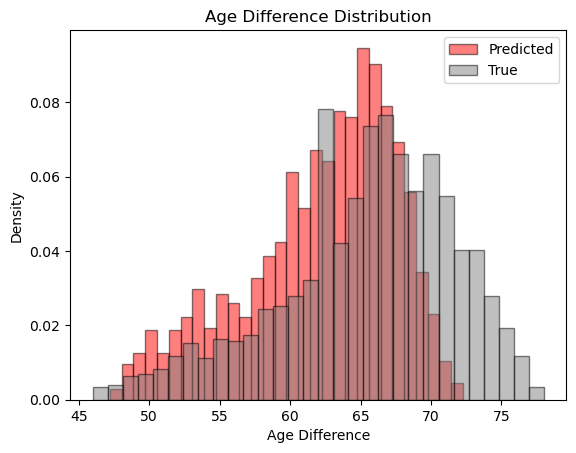

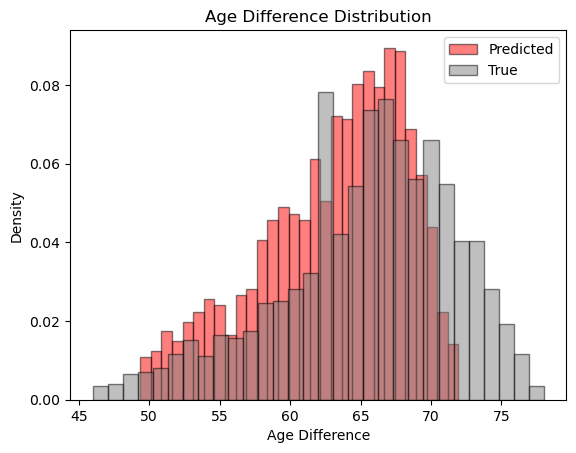

In [34]:
for key, region in regions.items():
    calculate_age_diff_dist(disease_ages,region)